In [0]:
# Read CSVs from DBFS
orders = spark.read.csv("dbfs:/FileStore/tables/instacart/orders.csv", header=True, inferSchema=True)
products = spark.read.csv("dbfs:/FileStore/tables/instacart/products.csv", header=True, inferSchema=True)
order_products_prior = spark.read.csv("dbfs:/FileStore/tables/instacart/order_products__prior.csv", header=True, inferSchema=True)
aisles = spark.read.csv("dbfs:/FileStore/tables/instacart/aisles.csv", header=True, inferSchema=True)
departments = spark.read.csv("dbfs:/FileStore/tables/instacart/departments.csv", header=True, inferSchema=True)


In [0]:
# Create SQL Views
orders.createOrReplaceTempView("orders")
products.createOrReplaceTempView("products")
order_products_prior.createOrReplaceTempView("order_products_prior")
aisles.createOrReplaceTempView("aisles")
departments.createOrReplaceTempView("departments")

📌 Q1: Top 10 Most Ordered Products

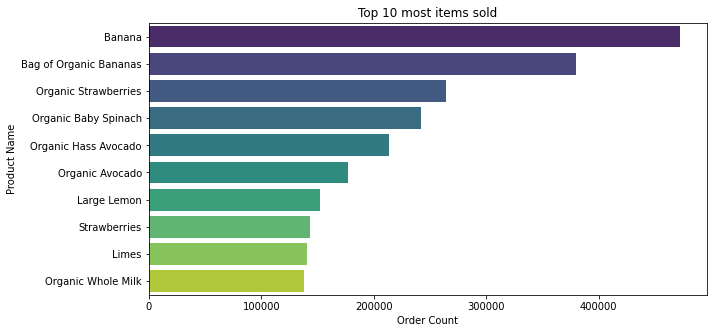

In [0]:
# Run SQL and convert to Pandas
top_products_df = spark.sql("""
SELECT p.product_name, COUNT(*) AS order_count
FROM order_products_prior opp
JOIN products p ON opp.product_id = p.product_id
GROUP BY p.product_name
ORDER BY order_count DESC
LIMIT 10
""").toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(x="order_count", y="product_name",data=top_products_df,palette="viridis")
plt.title("Top 10 most items sold")
plt.xlabel("Order Count")
plt.ylabel("Product Name")
plt.show()

📌 Q2: Top 10 Most Reordered Aisles

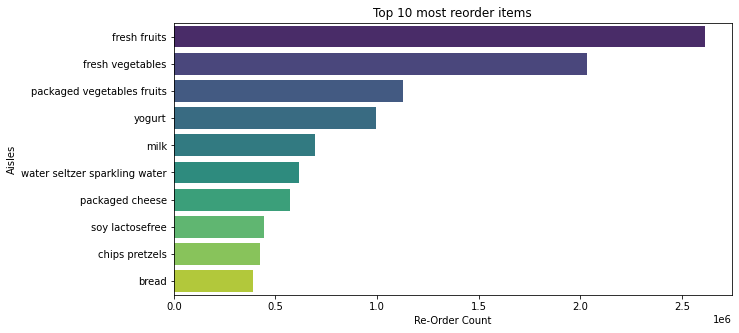

In [0]:
# Run SQL and convert to Pandas
top_asile_df = spark.sql("""
SELECT a.aisle, COUNT(*) AS reorder_count
FROM order_products_prior opp
JOIN products p ON opp.product_id = p.product_id
JOIN aisles a ON p.aisle_id = a.aisle_id
WHERE opp.reordered = 1
GROUP BY a.aisle
ORDER BY reorder_count DESC
LIMIT 10
""").toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(x="reorder_count", y="aisle",data=top_asile_df,palette="viridis")
plt.title("Top 10 most reorder items")
plt.xlabel("Re-Order Count")
plt.ylabel("Aisles")
plt.show()

📌 Q3: Top 10 Average Basket Sizes per User

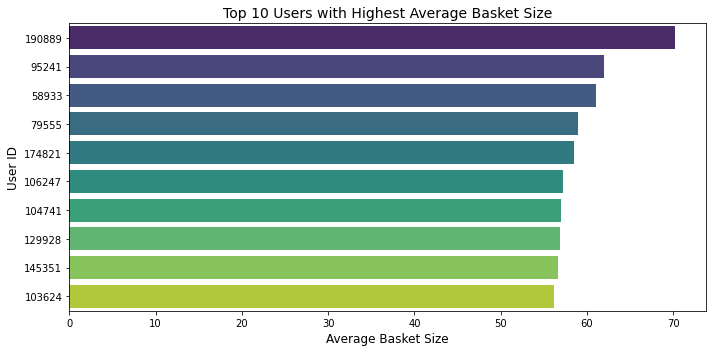

In [0]:
# Run SQL and convert to Pandas
avg_basket_df = spark.sql("""
SELECT user_id, AVG(basket_size) AS avg_basket_size
FROM (
  SELECT o.user_id, o.order_id, COUNT(opp.product_id) AS basket_size
  FROM orders o
  JOIN order_products_prior opp ON o.order_id = opp.order_id
  GROUP BY o.user_id, o.order_id
) basket_sizes
GROUP BY user_id
ORDER BY avg_basket_size DESC
LIMIT 10
""").toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

# Fix user_id data type
avg_basket_df['user_id'] = avg_basket_df['user_id'].astype(str)

# Now plot with horizontal bars
plt.figure(figsize=(10,5))
sns.barplot(x="avg_basket_size", y="user_id", data=avg_basket_df, palette="viridis")
plt.title("Top 10 Users with Highest Average Basket Size", fontsize=14)
plt.xlabel("Average Basket Size", fontsize=12)
plt.ylabel("User ID", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()




📌 Q4: Market Size Distribution

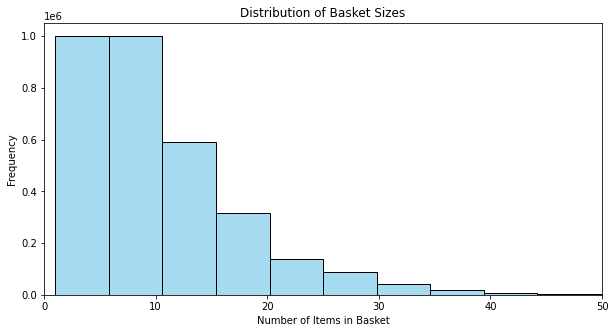

In [0]:
basket_size_df = spark.sql("""
SELECT o.user_id, o.order_id, COUNT(opp.product_id) AS basket_size
FROM orders o
JOIN order_products_prior opp 
  ON o.order_id = opp.order_id
GROUP BY o.user_id, o.order_id
""").toPandas()

plt.figure(figsize=(10,5))
sns.histplot(basket_size_df['basket_size'], bins=30, kde=False, color='skyblue')
plt.title("Distribution of Basket Sizes")
plt.xlabel("Number of Items in Basket")
plt.ylabel("Frequency")
plt.xlim(0, 50)  # Limit x-axis for clarity
plt.show()



📌 Q5: Order Count by Day of Week and Hour of Day

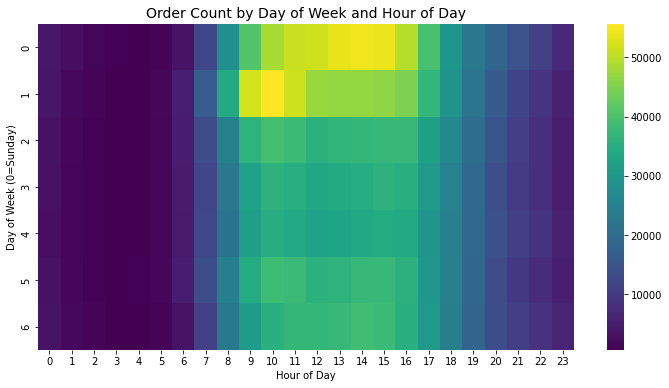

In [0]:
orders_by_time_df = spark.sql("""
SELECT 
    order_dow AS day_of_week,
    order_hour_of_day AS hour_of_day,
    COUNT(*) AS order_count
FROM orders
GROUP BY order_dow, order_hour_of_day
ORDER BY day_of_week, hour_of_day
""").toPandas()
heatmap_data = orders_by_time_df.pivot(
    index="day_of_week", 
    columns="hour_of_day", 
    values="order_count"
)
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap="viridis")
plt.title("Order Count by Day of Week and Hour of Day", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week (0=Sunday)")
plt.show()
